# Tutorial: fitting a FSRQ broad-band SED using angpy and sherpa

In this tutorial we will show how to write a small `sherpa` wrapper of the `agnpy` functions that will allow us to fit the broad-band SED of PKS1510-089 measured during its gamma-ray flaring activity in 2015 [(Ahnen et al. 2017)](https://ui.adsabs.harvard.edu/abs/2017A%26A...603A..29A/abstract). We select the MWL SED corresponding to
the period identified in the paper as "Period B" (MJD 57164-57166). 

[sherpa](https://sherpa.readthedocs.io/en/latest/index.html) is required to run this notebook.

In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import numpy as np
import astropy.units as u
from astropy.constants import c, G, k_B, m_e, M_sun
from astropy.coordinates import Distance
from pathlib import Path
from astropy.table import Table
import matplotlib.pyplot as plt
import pkg_resources

In [2]:
# import agnpy classes
import agnpy
from agnpy.emission_regions import Blob
from agnpy.spectra import BrokenPowerLaw
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton, ExternalCompton
from agnpy.targets import RingDustTorus, SSDisk
from agnpy.utils.plot import load_mpl_rc, sed_x_label, sed_y_label, plot_sed
load_mpl_rc()

In [3]:
# import sherpa classes
from sherpa.models import model
from sherpa import data
from sherpa.fit import Fit
from sherpa.stats import Chi2
from sherpa.optmethods import LevMar

In [4]:
# constants
mec2 = m_e.to("erg", equivalencies=u.mass_energy())
gamma_size = 400
gamma_to_integrate = np.logspace(0, 7, gamma_size)

### sherpa wrapper of agnpy synchrotron, SSC and EC on DT
Now let us [follow the sherpa documentation](https://sherpa.readthedocs.io/en/latest/model_classes/usermodel.html) and define a model wrapping agnpy's functions to compute the Synchrotron, Synchrotron Self-Compton and External Compton on Dust Torus SEDs. We will assume a broken power law electorn distribution. The thermal SEDs of the Disk and the DT are added to the total flux.

**NOTE:** for the parameters that vary over several orders of magnitude (i.e. normalisation and Lorentz factors of the electron distirbutions) it is better to provide to the fitting routine a "scaled" version of them (e.g. their log10), such that larger steps might be covered with small parameters variation.

**NOTE:** the size of the blob $R_{\rm b}$ is constrained through the variability time scale $t_{\rm var}$ and the Doppler factor via: $R_{\rm b} = (c t_{\rm var} \delta_{\rm D}) / (1 + z)$.

In [5]:
class AgnpyEC(model.RegriddableModel1D):
    """Wrapper of agnpy's non synchrotron, SSC and EC classes. The flux model
    accounts for the Disk and DT's thermal SEDs. 
    A broken power law is assumed for the electron spectrum.
    To limit the span of the parameters space, we fit the log10 of the parameters 
    whose range is expected to cover several orders of magnitudes (normalisation, 
    gammas, size and magnetic field of the blob). 
    """

    def __init__(self, name="ec"):

        # EED parameters
        self.log10_k_e = model.Parameter(name, "log10_k_e", -2.0, min=-20.0, max=10.0)
        self.p1 = model.Parameter(name, "p1", 2.1, min=-2.0, max=5.0)
        self.p2 = model.Parameter(name, "p2", 3.1, min=-2.0, max=5.0)
        self.log10_gamma_b = model.Parameter(name, "log10_gamma_b", 3, min=1, max=6)
        self.log10_gamma_min = model.Parameter(name, "log10_gamma_min", 1, min=0, max=4)
        self.log10_gamma_max = model.Parameter(name, "log10_gamma_max", 5, min=4, max=8)
        # source general parameters
        self.z = model.Parameter(name, "z", 0.1, min=0.01, max=1)
        self.d_L = model.Parameter(name, "d_L", 1e27, min=1e25, max=1e33, units="cm")
        # emission region parameters
        self.delta_D = model.Parameter(name, "delta_D", 10, min=0, max=40)
        self.log10_B = model.Parameter(name, "log10_B", -2, min=-4, max=2)
        self.t_var = model.Parameter(
            name, "t_var", 600, min=10, max=np.pi * 1e7, units="s"
        )
        self.mu_s = model.Parameter(name, "mu_s", 0.9, min=0.0, max=1.0)
        self.log10_r = model.Parameter(name, "log10_r", 17.0, min=16.0, max=20.0)
        # disk parameters
        self.log10_L_disk = model.Parameter(
            name, "log10_L_disk", 45.0, min=42.0, max=48.0
        )
        self.log10_M_BH = model.Parameter(name, "log10_M_BH", 42, min=32, max=45)
        self.m_dot = model.Parameter(
            name, "m_dot", 1e26, min=1e24, max=1e30, units="g s-1"
        )
        self.R_in = model.Parameter(name, "R_in", 1e14, min=1e12, max=1e16, units="cm")
        self.R_out = model.Parameter(
            name, "R_out", 1e17, min=1e12, max=1e19, units="cm"
        )
        # DT parameters
        self.xi_dt = model.Parameter(name, "xi_dt", 0.6, min=0.0, max=1.0)
        self.T_dt = model.Parameter(
            name, "T_dt", 1.0e3, min=1.0e2, max=1.0e4, units="K"
        )
        self.R_dt = model.Parameter(
            name, "R_dt", 2.5e18, min=1.0e17, max=1.0e19, units="cm"
        )

        model.RegriddableModel1D.__init__(
            self,
            name,
            (
                self.log10_k_e,
                self.p1,
                self.p2,
                self.log10_gamma_b,
                self.log10_gamma_min,
                self.log10_gamma_max,
                self.z,
                self.d_L,
                self.delta_D,
                self.log10_B,
                self.t_var,
                self.mu_s,
                self.log10_r,
                self.log10_L_disk,
                self.log10_M_BH,
                self.m_dot,
                self.R_in,
                self.R_out,
                self.xi_dt,
                self.T_dt,
                self.R_dt,
            ),
        )

    def calc(self, pars, x):
        """evaluate the model calling the agnpy functions"""
        (
            log10_k_e,
            p1,
            p2,
            log10_gamma_b,
            log10_gamma_min,
            log10_gamma_max,
            z,
            d_L,
            delta_D,
            log10_B,
            t_var,
            mu_s,
            log10_r,
            log10_L_disk,
            log10_M_BH,
            m_dot,
            R_in,
            R_out,
            xi_dt,
            T_dt,
            R_dt,
        ) = pars
        # add units, scale quantities
        x *= u.Hz
        k_e = 10 ** log10_k_e * u.Unit("cm-3")
        gamma_b = 10 ** log10_gamma_b
        gamma_min = 10 ** log10_gamma_min
        gamma_max = 10 ** log10_gamma_max
        B = 10 ** log10_B * u.G
        R_b = c.to_value("cm s-1") * t_var * delta_D / (1 + z) * u.cm
        r = 10 ** log10_r * u.cm
        d_L *= u.cm
        L_disk = 10 ** log10_L_disk * u.Unit("erg s-1")
        M_BH = 10 ** log10_M_BH * u.Unit("g")
        m_dot *= u.Unit("g s-1")
        R_in *= u.cm
        R_out *= u.cm
        R_dt *= u.cm
        T_dt *= u.K
        eps_dt = 2.7 * (k_B * T_dt / mec2).to_value("")

        # non-thermal components
        sed_synch = Synchrotron.evaluate_sed_flux(
            x,
            z,
            d_L,
            delta_D,
            B,
            R_b,
            BrokenPowerLaw,
            k_e,
            p1,
            p2,
            gamma_b,
            gamma_min,
            gamma_max,
            ssa=True,
            gamma=gamma_to_integrate,
        )
        sed_ssc = SynchrotronSelfCompton.evaluate_sed_flux(
            x,
            z,
            d_L,
            delta_D,
            B,
            R_b,
            BrokenPowerLaw,
            k_e,
            p1,
            p2,
            gamma_b,
            gamma_min,
            gamma_max,
            ssa=True,
            gamma=gamma_to_integrate,
        )
        sed_ec_dt = ExternalCompton.evaluate_sed_flux_dt(
            x,
            z,
            d_L,
            delta_D,
            mu_s,
            R_b,
            L_disk,
            xi_dt,
            eps_dt,
            R_dt,
            r,
            BrokenPowerLaw,
            k_e,
            p1,
            p2,
            gamma_b,
            gamma_min,
            gamma_max,
            gamma=gamma_to_integrate,
        )
        # thermal components
        sed_bb_disk = SSDisk.evaluate_multi_T_bb_norm_sed(
            x, z, L_disk, M_BH, m_dot, R_in, R_out, d_L
        )
        sed_bb_dt = RingDustTorus.evaluate_bb_norm_sed(
            x, z, xi_dt * L_disk, T_dt, R_dt, d_L
        )
        return sed_synch + sed_ssc + sed_ec_dt + sed_bb_disk + sed_bb_dt

### Fitting with sherpa
Let us start here the procedure to fit with sherpa, first we read the data and then we pass them in a `Data1D` object provided by sherpa. We add an arbitrary 10% systematic error on the flux measurements. This is an arbitrary assumption made to improve the fit, it does not represent a precise error estimation.

In [6]:
# read the 1D data
sed_path = pkg_resources.resource_filename("agnpy", "data/mwl_seds/PKS1510-089_2015b.ecsv")
sed_table = Table.read(sed_path)
x = sed_table["e_ref"].to("Hz", equivalencies=u.spectral())
y = sed_table["e2dnde"] 
y_err_stat = sed_table["e2dnde_errn"]
# add an arbitrary 10% systematic error on the flux measurement
y_err_syst = 0.1 * y 
# load them in a sherpa data object
sed = data.Data1D("sed", x, y, staterror=y_err_stat, syserror=y_err_syst)

Create an instance of the model wrapping the synchrotron, SSC and EC on DT emissions.

In [7]:
# declare a model
agnpy_ec = AgnpyEC()
# global parameters of the blob and the DT
z = 0.361
d_L = Distance(z=z).to("cm")
# blob
Gamma = 20
delta_D = 25
Beta = np.sqrt(1 - 1 / np.power(Gamma, 2))  # jet relativistic speed
mu_s = (1 - 1 / (Gamma * delta_D)) / Beta  # viewing angle
B = 0.35 * u.G
# disk
L_disk = 6.7e45 * u.Unit("erg s-1")  # disk luminosity
M_BH = 5.71 * 1e7 * M_sun
eta = 1 / 12
m_dot = (L_disk / (eta * c ** 2)).to("g s-1")
R_g = ((G * M_BH) / c ** 2).to("cm")
R_in = 6 * R_g
R_out = 10000 * R_g
# DT
xi_dt = 0.6  # fraction of disk luminosity reprocessed by the DT
T_dt = 1e3 * u.K
R_dt = 6.47 * 1e18 * u.cm
# size and location of the emission region
t_var = 0.5 * u.d
r = 6e17 * u.cm
# instance of the model wrapping angpy functionalities
# - AGN parameters
# -- distances
agnpy_ec.z = z
agnpy_ec.z.freeze()
agnpy_ec.d_L = d_L.cgs.value
agnpy_ec.d_L.freeze()
# -- SS disk
agnpy_ec.log10_L_disk = np.log10(L_disk.to_value("erg s-1"))
agnpy_ec.log10_L_disk.freeze()
agnpy_ec.log10_M_BH = np.log10(M_BH.to_value("g"))
agnpy_ec.log10_M_BH.freeze()
agnpy_ec.m_dot = m_dot.to_value("g s-1")
agnpy_ec.m_dot.freeze()
agnpy_ec.R_in = R_in.to_value("cm")
agnpy_ec.R_in.freeze()
agnpy_ec.R_out = R_out.to_value("cm")
agnpy_ec.R_out.freeze()
# -- Dust Torus
agnpy_ec.xi_dt = xi_dt
agnpy_ec.xi_dt.freeze()
agnpy_ec.T_dt = T_dt.to_value("K")
agnpy_ec.T_dt.freeze()
agnpy_ec.R_dt = R_dt.to_value("cm")
agnpy_ec.R_dt.freeze()
# - blob parameters
agnpy_ec.delta_D = delta_D
agnpy_ec.delta_D.freeze()
agnpy_ec.log10_B = np.log10(B.to_value("G"))
agnpy_ec.mu_s = mu_s
agnpy_ec.mu_s.freeze()
agnpy_ec.t_var = (t_var).to_value("s")
agnpy_ec.t_var.freeze()
agnpy_ec.log10_r = np.log10(r.to_value("cm"))
agnpy_ec.log10_r.freeze()
# - EED
agnpy_ec.log10_k_e = np.log10(0.05)
agnpy_ec.p1 = 1.8
agnpy_ec.p2 = 3.5
agnpy_ec.log10_gamma_b = np.log10(500)
agnpy_ec.log10_gamma_min = np.log10(1)
agnpy_ec.log10_gamma_min.freeze()
agnpy_ec.log10_gamma_max = np.log10(3e4)
agnpy_ec.log10_gamma_max.freeze()

Now we define the Fit procedure choosing the statistics (chi2) and the minimisation method. We will fit only the data between $10^{10}\,{\rm Hz}$ and $10^{27}\,{\rm Hz}$, avoiding the lowest-energy radio data usually attributed to the extended jet emission.

In [8]:
# fit using the Levenberg-Marquardt optimiser
fitter = Fit(sed, agnpy_ec, stat=Chi2(), method=LevMar())
min_x = 1e11 * u.Hz
max_x = 1e30 * u.Hz
sed.notice(min_x, max_x)

In [9]:
%%time
# perform the fit and time it!
results = fitter.fit()
print("-- fit succesful?", results.succeeded)
print(results.format())

-- fit succesful? True
Method                = levmar
Statistic             = chi2
Initial fit statistic = 790.55
Final fit statistic   = 75.7327 at function evaluation 82
Data points           = 41
Degrees of freedom    = 36
Probability [Q-value] = 0.000119798
Reduced statistic     = 2.10369
Change in statistic   = 714.817
   ec.log10_k_e   -2.33385     +/- 0.421856    
   ec.p1          2.04811      +/- 0.0769668   
   ec.p2          3.15639      +/- 0.0596261   
   ec.log10_gamma_b   3.04041      +/- 0.144132    
   ec.log10_B     -0.43606     +/- 0.0257344   
CPU times: user 44.8 s, sys: 4.24 s, total: 49.1 s
Wall time: 50.1 s


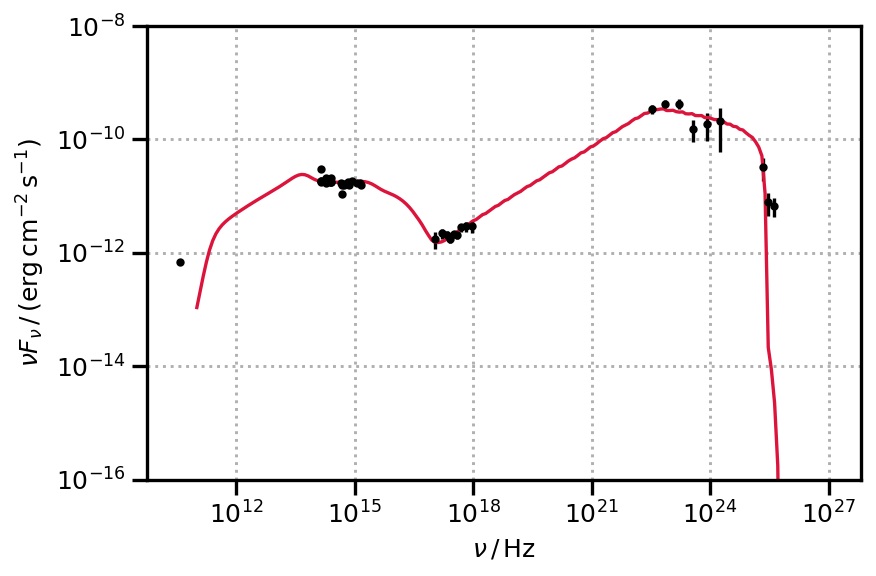

In [10]:
# plot the results!
x = np.logspace(11, 27, 200)
plt.errorbar(sed.x, sed.y, yerr=sed.get_error(), marker=".", ls="", color="k")
plot_sed(x, agnpy_ec(x), ls="-", color="crimson")
plt.ylim([1e-16, 1e-8])
plt.show()

### Draw individual SED components using agnpy
Let us now load the sherpa results in agnpy's objects and draw the individual SED components

In [11]:
k_e = 10 ** agnpy_ec.log10_k_e.val * u.Unit("cm-3")
p1 = agnpy_ec.p1.val
p2 = agnpy_ec.p2.val
gamma_b = 10 ** agnpy_ec.log10_gamma_b.val
gamma_min = 10 ** agnpy_ec.log10_gamma_min.val
gamma_max = 10 ** agnpy_ec.log10_gamma_max.val
B = 10 ** agnpy_ec.log10_B.val * u.G
r = 10 ** agnpy_ec.log10_r.val * u.cm
delta_D = agnpy_ec.delta_D.val
R_b = c.to_value("cm s-1") * agnpy_ec.t_var.val * delta_D / (1 + z) * u.cm
# blob definition
parameters = {
    "p1": p1,
    "p2": p2,
    "gamma_b": gamma_b,
    "gamma_min": gamma_min,
    "gamma_max": gamma_max,
}
spectrum_dict = {"type": "BrokenPowerLaw", "parameters": parameters}
blob = Blob(
    R_b,
    z,
    delta_D,
    Gamma,
    B,
    k_e,
    spectrum_dict,
    spectrum_norm_type="differential",
    gamma_size=500,
)
print(blob)
print(f"jet power in particles: {blob.P_jet_e:.2e}")
print(f"jet power in B: {blob.P_jet_B:.2e}")

# Disk and DT definition
L_disk = 10 ** agnpy_ec.log10_L_disk.val * u.Unit("erg s-1")
M_BH = 10 ** agnpy_ec.log10_M_BH.val * u.Unit("g")
m_dot = agnpy_ec.m_dot.val * u.Unit("g s-1")
eta = (L_disk / (m_dot * c ** 2)).to_value("")
R_in = agnpy_ec.R_in.val * u.cm
R_out = agnpy_ec.R_out.val * u.cm
disk = SSDisk(M_BH, L_disk, eta, R_in, R_out)
dt = RingDustTorus(L_disk, xi_dt, T_dt, R_dt=R_dt)

# radiative processes
synch = Synchrotron(blob, ssa=True)
ssc = SynchrotronSelfCompton(blob, synch)
ec_dt = ExternalCompton(blob, dt, r)
# SEDs
nu = np.logspace(9, 27, 200) * u.Hz
synch_sed = synch.sed_flux(nu)
ssc_sed = ssc.sed_flux(nu)
ec_dt_sed = ec_dt.sed_flux(nu)
disk_bb_sed = disk.sed_flux(nu, z)
dt_bb_sed = dt.sed_flux(nu, z)
total_sed = synch_sed + ssc_sed + ec_dt_sed + disk_bb_sed + dt_bb_sed

* spherical emission region
 - R_b (radius of the blob): 2.38e+16 cm
 - V_b (volume of the blob): 5.64e+49 cm3
 - z (source redshift): 0.36
 - d_L (source luminosity distance):6.13e+27 cm
 - delta_D (blob Doppler factor): 2.50e+01
 - Gamma (blob Lorentz factor): 2.00e+01
 - Beta (blob relativistic velocity): 9.99e-01
 - theta_s (jet viewing angle): 2.22e+00 deg
 - B (magnetic field tangled to the jet): 3.66e-01 G
 - xi (coefficient for 1st order Fermi acceleration) : 1.00e+00
* electron spectrum
 - broken power law
 - k_e: 4.64e-03 1 / cm3
 - p1: 2.05
 - p2: 3.16
 - gamma_b: 1.10e+03
 - gamma_min: 1.00e+00
 - gamma_max: 3.00e+04

jet power in particles: 1.79e+45 erg / s
jet power in B: 2.27e+44 erg / s


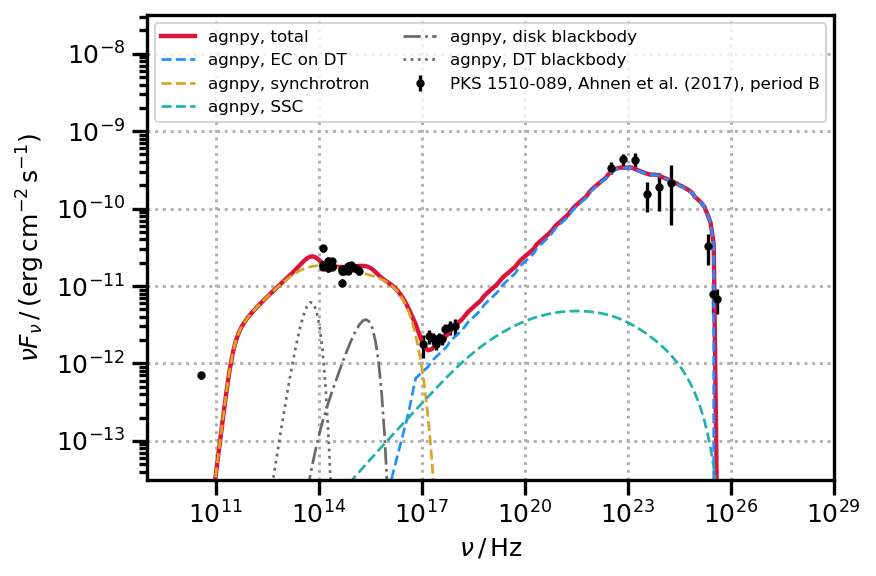

In [12]:
# final plot
load_mpl_rc()
fig, ax = plt.subplots()
ax.loglog(
    nu / (1 + z), total_sed, ls="-", lw=2.1, color="crimson", label="agnpy, total"
)
ax.loglog(
    nu / (1 + z),
    ec_dt_sed,
    ls="--",
    lw=1.3,
    color="dodgerblue",
    label="agnpy, EC on DT",
)
ax.loglog(
    nu / (1 + z),
    synch_sed,
    ls="--",
    lw=1.3,
    color="goldenrod",
    label="agnpy, synchrotron",
)
ax.loglog(
    nu / (1 + z), ssc_sed, ls="--", lw=1.3, color="lightseagreen", label="agnpy, SSC"
)
ax.loglog(
    nu / (1 + z),
    disk_bb_sed,
    ls="-.",
    lw=1.3,
    color="dimgray",
    label="agnpy, disk blackbody",
)
ax.loglog(
    nu / (1 + z),
    dt_bb_sed,
    ls=":",
    lw=1.3,
    color="dimgray",
    label="agnpy, DT blackbody",
)
# statistics error in black
ax.errorbar(
    sed.x,
    sed.y,
    yerr=sed.get_error(),
    marker=".",
    ls="",
    color="k",
    label="PKS 1510-089, Ahnen et al. (2017), period B",
)
ax.set_xlabel(sed_x_label)
ax.set_ylabel(sed_y_label)
ax.set_xlim([1e9, 1e29])
ax.set_ylim([10 ** (-13.5), 10 ** (-7.5)])
ax.legend(
    loc="upper center", fontsize=8, ncol=2,
)
plt.show()